# Проект: Классификация при помощи CNN. 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

Для VSCode\
`pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126`

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

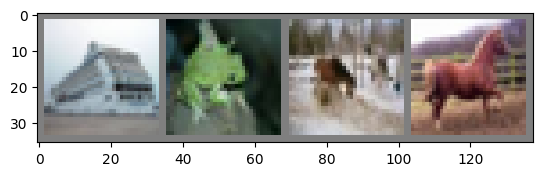

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        # первый слой
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        # второй слой
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, bias=False), 
            nn.BatchNorm2d(32),
        )

        self.avg_pool = nn.AvgPool2d(kernel_size=8) 
        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        identity = x  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if identity.shape[1] != out.shape[1]:
            identity = self.downsample(identity)
            
        out += identity
        out = self.relu(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
net = net.to(device)

## 2. Обучение и тестирование модели 

In [11]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():  
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = F.cross_entropy(output, target)
            loss_log.append(loss.item())

            pred = output.argmax(dim=1)
            acc = (pred == target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

In [12]:
def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log

In [13]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах ограничусь 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    model=net, 
    optimizer=optimizer, 
    n_epochs=20, 
    train_loader=train_loader, 
    val_loader=val_loader
)

Epoch 0
 train loss: 1.4731886318222478, train acc: 0.4781927396653993
 val loss: 1.2513684853594353, val acc: 0.5621675531914894

Epoch 1
 train loss: 1.159637240757672, train acc: 0.5937704035307415
 val loss: 1.078228619758119, val acc: 0.6195478723404255

Epoch 2
 train loss: 1.0403122053067906, train acc: 0.636177037163234
 val loss: 1.038786394038099, val acc: 0.641533688027808

Epoch 3
 train loss: 0.9795560270166485, train acc: 0.6601348263254113
 val loss: 0.9671502460824682, val acc: 0.6677304965384463

Epoch 4
 train loss: 0.948230747548928, train acc: 0.671352670441162
 val loss: 0.9624964473095347, val acc: 0.6688829787234043

Epoch 5
 train loss: 0.9078494265702787, train acc: 0.6856473623289705
 val loss: 0.961391475606472, val acc: 0.6661125888215734

Epoch 6
 train loss: 0.8933940439381155, train acc: 0.6899933077299617
 val loss: 0.9562981265656492, val acc: 0.6734707446808511

Epoch 7
 train loss: 0.8717328792189332, train acc: 0.6958164665337236
 val loss: 0.9064367

In [15]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.91%
Test Accuracy: 0.70%


In [16]:
def plot_metrics(train_loss, train_acc, val_loss, val_acc, train_loader):
    """
    Функция построения графиков (1 - функция потерь, 2 - точность)
    """
    iter_per_epoch = len(train_loader)
    val_iterations = [(i + 1) * iter_per_epoch for i in range(len(val_loss))]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_loss)), train_loss, label='train_loss', alpha=0.6)
    plt.plot(val_iterations, val_loss, 'o-', label='val_loss', markersize=8)
    plt.xlabel('Этап оптимизации')
    plt.ylabel('Потеря')
    plt.title('Потеря vs Этап оптимизации')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_acc)), train_acc, label='train_acc', alpha=0.6)
    plt.plot(val_iterations, val_acc, 'o-', label='val_acc', markersize=8)
    plt.xlabel('Этап оптимизации')
    plt.ylabel('Точность (%)')
    plt.title('Точность vs Этап оптимизации')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

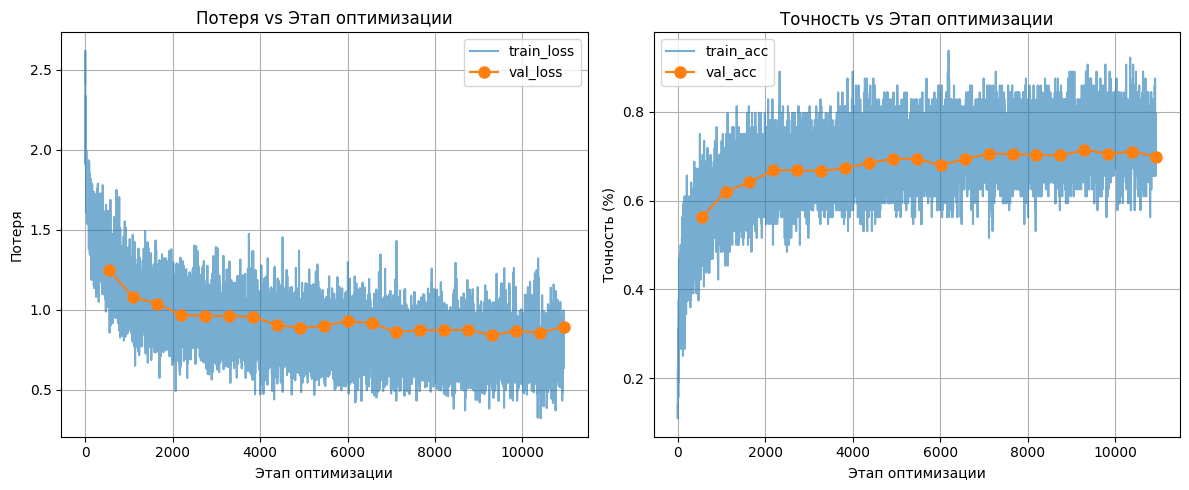

In [17]:
plot_metrics(train_loss_log, train_acc_log, val_loss_log, val_acc_log, train_loader)

## 3. Расписание длины шага 

In [25]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    model=net, 
    optimizer=optimizer, 
    n_epochs=20, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    scheduler=scheduler
)

Epoch 0
 train loss: 1.525838551181326, train acc: 0.4582993275395695
 val loss: 1.2803500695431487, val acc: 0.5474512412192973

Epoch 1
 train loss: 1.204591201689823, train acc: 0.5773211021310015
 val loss: 1.2027166729277752, val acc: 0.582734929120287

Epoch 2
 train loss: 1.0694328468068208, train acc: 0.6294969313759254
 val loss: 1.0348743913021494, val acc: 0.6361258866939139

Epoch 3
 train loss: 1.0020637069803269, train acc: 0.6501044659335609
 val loss: 1.071901992787706, val acc: 0.630407801587531

Epoch 4
 train loss: 0.969796851304593, train acc: 0.6605265735490231
 val loss: 0.9989283282706078, val acc: 0.6514849292471053

Epoch 5
 train loss: 0.9430607734912057, train acc: 0.6733318099809957
 val loss: 0.9557321720934929, val acc: 0.6658687944107867

Epoch 6
 train loss: 0.9110542650196627, train acc: 0.6811259467379485
 val loss: 0.9340220839419263, val acc: 0.6758200356300841

Epoch 7
 train loss: 0.8905453923851306, train acc: 0.6920785453899251
 val loss: 0.91395

точность на тестовой выборке:

In [27]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.82%
Test Accuracy: 0.72%


Точность увеличилась 

In [23]:
net_fixed_lr = BasicBlockNet().to(device)
optimizer_fixed = optim.SGD(net_fixed_lr.parameters(), lr=0.001, momentum=0.9)

train_loss_fixed, train_acc_fixed, val_loss_fixed, val_acc_fixed = train(
    model=net_fixed_lr,
    optimizer=optimizer_fixed,
    n_epochs=20,              # число эпох, как и выше
    train_loader=train_loader,
    val_loader=val_loader
)

Epoch 0
 train loss: 1.783916661464754, train acc: 0.37053163363249253
 val loss: 1.5711337515648376, val acc: 0.4496897163543295

Epoch 1
 train loss: 1.4955791605456001, train acc: 0.4735121768396995
 val loss: 1.4203817418281068, val acc: 0.49789450358837206

Epoch 2
 train loss: 1.3851296973620735, train acc: 0.5099813920706238
 val loss: 1.3354440531832106, val acc: 0.5349512412192974

Epoch 3
 train loss: 1.3162379527440673, train acc: 0.5369425764685357
 val loss: 1.2878100354620752, val acc: 0.5499335106382979

Epoch 4
 train loss: 1.2686303367998308, train acc: 0.5536163162705667
 val loss: 1.2396502114356833, val acc: 0.5627437944107867

Epoch 5
 train loss: 1.2249772104092447, train acc: 0.5722079851291734
 val loss: 1.2001482339615517, val acc: 0.5796985816448292

Epoch 6
 train loss: 1.1929136477615105, train acc: 0.5843521481894052
 val loss: 1.1673513833512652, val acc: 0.591688829787234

Epoch 7
 train loss: 1.1552030911611246, train acc: 0.5954924589755113
 val loss: 1

In [24]:
test_loss, test_acc = test(net_fixed_lr, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.96%
Test Accuracy: 0.66%


Точность сильно упало, как и должно было быть

In [29]:
"""
Попробую StepLR. Он уменьшает скорость обучения на определенный коэф каждые step_size эпох
"""
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    model=net, 
    optimizer=optimizer, 
    n_epochs=20, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    scheduler=scheduler
)

Epoch 0
 train loss: 1.5301858602973617, train acc: 0.4574342191328296
 val loss: 1.3103928766352064, val acc: 0.5407801420130628

Epoch 1
 train loss: 1.2162379593038473, train acc: 0.573925959889588
 val loss: 1.1611407820214616, val acc: 0.5962765957446808

Epoch 2
 train loss: 1.0831429479980816, train acc: 0.6238410812845178
 val loss: 1.0546985009883312, val acc: 0.6410682624958931

Epoch 3
 train loss: 1.0193673513925054, train acc: 0.6478437581925331
 val loss: 1.0210476233604107, val acc: 0.6482712765957447

Epoch 4
 train loss: 0.9730204699026384, train acc: 0.6648357926818527
 val loss: 0.9946882803389366, val acc: 0.6561391845662543

Epoch 5
 train loss: 0.8465631381358264, train acc: 0.708425829244924
 val loss: 0.8918167877704539, val acc: 0.6941046100981692

Epoch 6
 train loss: 0.8269208684917778, train acc: 0.7160159311303272
 val loss: 0.8801337475472308, val acc: 0.699468085106383

Epoch 7
 train loss: 0.8212207802035038, train acc: 0.7179338600779365
 val loss: 0.87

In [30]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.87%
Test Accuracy: 0.70%


In [33]:
"""
Попробую CosineAnnealingLR. Так lr меняется по косинусоиде: плавно уменьшается и может снова возрастать
"""
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    model=net, 
    optimizer=optimizer, 
    n_epochs=20, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    scheduler=scheduler
)

Epoch 0
 train loss: 1.4764457865868452, train acc: 0.4770746279024337
 val loss: 1.335786426320989, val acc: 0.5362145390916377

Epoch 1
 train loss: 1.16857524011863, train acc: 0.591105706513037
 val loss: 1.108017977247847, val acc: 0.6207446808510638

Epoch 2
 train loss: 1.0693213752244464, train acc: 0.632924719310112
 val loss: 1.1942332369215944, val acc: 0.5930407803109352

Epoch 3
 train loss: 1.0065474744470726, train acc: 0.6506431183387854
 val loss: 1.0290361784874125, val acc: 0.6407801420130628

Epoch 4
 train loss: 0.9610704853722121, train acc: 0.6661375360035591
 val loss: 0.9596770740569907, val acc: 0.668439716481148

Epoch 5
 train loss: 0.9317161150998564, train acc: 0.6763637700072155
 val loss: 0.9935091995178384, val acc: 0.6489804965384462

Epoch 6
 train loss: 0.9025886454355564, train acc: 0.6867287477148081
 val loss: 0.9283259698685179, val acc: 0.6775709220703612

Epoch 7
 train loss: 0.8698466751431634, train acc: 0.6993177070042333
 val loss: 0.965915

In [34]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.82%
Test Accuracy: 0.72%


In [35]:
"""
Попробую OneCycleLR. Меняет lr от малого к большому и обратно
"""
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=20)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    model=net, 
    optimizer=optimizer, 
    n_epochs=20, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    scheduler=scheduler
)

Epoch 0
 train loss: 1.5527983651082737, train acc: 0.4461837294332724
 val loss: 1.378259952524875, val acc: 0.504144503588372

Epoch 1
 train loss: 1.2702747326228474, train acc: 0.5517595978062158
 val loss: 1.2888460557511512, val acc: 0.5505097518575952

Epoch 2
 train loss: 1.1430292569741034, train acc: 0.5968105250346377
 val loss: 1.0776779337132232, val acc: 0.6250886526513607

Epoch 3
 train loss: 1.0572762786797238, train acc: 0.631068000845761
 val loss: 1.037229437270063, val acc: 0.637876773134191

Epoch 4
 train loss: 1.0160412405918895, train acc: 0.6464236745886655
 val loss: 1.0369043114337515, val acc: 0.6395168441407224

Epoch 5
 train loss: 0.9699010309615127, train acc: 0.6606530753088607
 val loss: 1.0149409923147648, val acc: 0.6414228723404255

Epoch 6
 train loss: 0.9395238482538045, train acc: 0.673768444841479
 val loss: 0.9375949879910084, val acc: 0.6755540781832756

Epoch 7
 train loss: 0.9112292120617966, train acc: 0.6805260838494658
 val loss: 0.93178

In [36]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.83%
Test Accuracy: 0.72%


Лучше всего себя показал OneCycleLR в этом задании, но если смотреть на всё, то MultiStepLR выигрывает.

## 4. Аугментации данных 

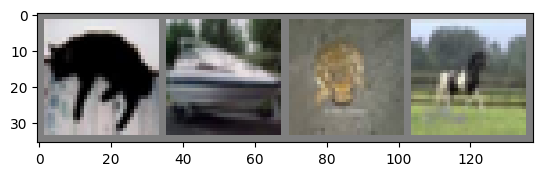

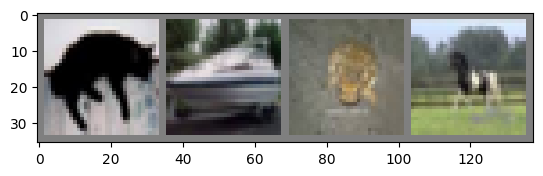

In [38]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [39]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.47574619695517, train acc: 0.4812002154765225
 val loss: 1.2024817745736305, val acc: 0.5813829787234043

Epoch 1
 train loss: 1.1697046641239954, train acc: 0.5932195090724519
 val loss: 1.2202834235860947, val acc: 0.5695478723404256

Epoch 2
 train loss: 1.0684003543374307, train acc: 0.628182946001154
 val loss: 1.1962097609296758, val acc: 0.589029255319149

Epoch 3
 train loss: 1.0139897169317145, train acc: 0.6497290415563357
 val loss: 0.9877897901737943, val acc: 0.6563386526513607

Epoch 4
 train loss: 0.9753334014463686, train acc: 0.6608163032278936
 val loss: 0.9764566132362853, val acc: 0.6634308510638298

Epoch 5
 train loss: 0.9455718250989478, train acc: 0.6704916427732603
 val loss: 0.9751426633368148, val acc: 0.6598625886947551

Epoch 6
 train loss: 0.9291987395155801, train acc: 0.6765759663564413
 val loss: 0.9242675857341036, val acc: 0.6833998228641267

Epoch 7
 train loss: 0.912326129306605, train acc: 0.6846435100548446
 val loss: 0.9697

Посчитайте точность на тестовой выборке:

In [40]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.81%
Test Accuracy: 0.72%


In [43]:
"""
RandomVerticalFlip - С вероятностью 0.5 переворачивает изображение по вертикали
"""
transform = transforms.Compose(
    [
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.6574516738790481, train acc: 0.4023978193673617
 val loss: 1.43232293230422, val acc: 0.48238031914893614

Epoch 1
 train loss: 1.3911623620245968, train acc: 0.5034685949956695
 val loss: 1.4961104032841135, val acc: 0.4786790781832756

Epoch 2
 train loss: 1.2915629682418852, train acc: 0.5424147950012026
 val loss: 1.3337535642563028, val acc: 0.5403147164811479

Epoch 3
 train loss: 1.2173416262570858, train acc: 0.5697718073070812
 val loss: 1.2379948430872978, val acc: 0.5631427305809995

Epoch 4
 train loss: 1.1718965969312343, train acc: 0.587955406204656
 val loss: 1.1933608813488736, val acc: 0.5797429079705096

Epoch 5
 train loss: 1.1434111421897164, train acc: 0.5984060786106032
 val loss: 1.1800613408393048, val acc: 0.5770611702127659

Epoch 6
 train loss: 1.1221139891927814, train acc: 0.6045108057245258
 val loss: 1.1663645204077375, val acc: 0.5925088654173182

Epoch 7
 train loss: 1.100636741360973, train acc: 0.6136638157110545
 val loss: 1.13

In [44]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.98%
Test Accuracy: 0.66%


In [46]:
"""
RandomRotation(degrees) - поворачивает изображение на случайный угол.
Подберу возможные значения degrees
"""
degree_values = [0, 10, 20, 30, 45]
results = {}

for degrees in degree_values:
    print(f"Training with RandomRotation({degrees})")

    transform = transforms.Compose([
        transforms.RandomRotation(degrees),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_loader, val_loader, test_loader = get_cifar10_data(
        batch_size=64, transform_train=transform
    )

    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

    tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
        net, optimizer, 20, train_loader, val_loader, scheduler
    )

    test_loss, test_acc = test(net, test_loader)
    results[degrees] = [test_loss, test_acc]

Training with RandomRotation(0)
Epoch 0
 train loss: 1.4706973873719, train acc: 0.4797760511882998
 val loss: 1.1779870824610934, val acc: 0.5894281914893617

Epoch 1
 train loss: 1.1627644865996658, train acc: 0.593737757946935
 val loss: 1.2886434270980511, val acc: 0.5627659574468085

Epoch 2
 train loss: 1.0480259359427737, train acc: 0.6357199987720092
 val loss: 1.1880480248877343, val acc: 0.5912455674181594

Epoch 3
 train loss: 0.9909449227331325, train acc: 0.6564744385112574
 val loss: 1.022571464041446, val acc: 0.6469636526513607

Epoch 4
 train loss: 0.9488466262163584, train acc: 0.6728829329584809
 val loss: 0.972342460713488, val acc: 0.6588874114320633

Epoch 5
 train loss: 0.916697858020636, train acc: 0.6846435100548446
 val loss: 0.9627609506566474, val acc: 0.6630762412192973

Epoch 6
 train loss: 0.898497750488888, train acc: 0.6884875294277394
 val loss: 0.9399797543566277, val acc: 0.6775930851063829

Epoch 7
 train loss: 0.8763467466264582, train acc: 0.69626

In [47]:
for degrees, (loss, acc) in results.items():
    print(f"degrees = {degrees}, Test Loss: {loss:.2f}%, Test Accuracy: {acc:.2f}%")

degrees = 0, Test Loss: 0.82%, Test Accuracy: 0.72%
degrees = 10, Test Loss: 0.84%, Test Accuracy: 0.71%
degrees = 20, Test Loss: 0.86%, Test Accuracy: 0.70%
degrees = 30, Test Loss: 0.90%, Test Accuracy: 0.68%
degrees = 45, Test Loss: 0.97%, Test Accuracy: 0.66%


In [48]:
""" 
ColorJitter(brightness, contrast, saturation, hue) - меняет яркость, контрастность, насыщенность и оттенок
Подберем параметры
"""
params_to_test = [
    (0.1, 0.1, 0.1, 0.05),
    (0.2, 0.2, 0.2, 0.1),
    (0.5, 0.5, 0.5, 0.3),
    (0.2, 0.1, 0.1, 0.05),
    (0.1, 0.2, 0.5, 0.1),
]
results = {}

for params in params_to_test:
    b, c, s, h = params
    transform = transforms.Compose(
        [
            transforms.ColorJitter(brightness=b, contrast=c, saturation=s, hue=h),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, val_loader, test_loader = get_cifar10_data(
        batch_size=64, transform_train=transform
    )

    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
    tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
        net, optimizer, 20, train_loader, val_loader, scheduler
    )
    test_loss, test_acc = test(net, test_loader)
    results[str(params)] = [test_loss, test_acc]

Epoch 0
 train loss: 1.4780182518078597, train acc: 0.4765767824497258
 val loss: 1.2147804133435514, val acc: 0.5770611702127659

Epoch 1
 train loss: 1.1568672716944484, train acc: 0.5974389528225719
 val loss: 1.1407827473701315, val acc: 0.6030585106382979

Epoch 2
 train loss: 1.0542555306467758, train acc: 0.635626142595978
 val loss: 1.1772290942516732, val acc: 0.5934840425531915

Epoch 3
 train loss: 0.9931770686257692, train acc: 0.6568784277879341
 val loss: 1.0009161378474947, val acc: 0.6540558510638298

Epoch 4
 train loss: 0.9511943694878322, train acc: 0.6719484526452896
 val loss: 1.0071004154834342, val acc: 0.6473625888215735

Epoch 5
 train loss: 0.9252889931092968, train acc: 0.6795181509999514
 val loss: 0.9944061210814943, val acc: 0.6533909574468085

Epoch 6
 train loss: 0.911775024107213, train acc: 0.6838844999316841
 val loss: 0.9642606402965302, val acc: 0.6659796099713509

Epoch 7
 train loss: 0.8879960168977107, train acc: 0.692041819012797
 val loss: 1.04

In [49]:
for params, (loss, acc) in results.items():
    print(f"params = {params}, Test Loss: {loss:.2f}%, Test Accuracy: {acc:.2f}%")

params = (0.1, 0.1, 0.1, 0.05), Test Loss: 0.82%, Test Accuracy: 0.73%
params = (0.2, 0.2, 0.2, 0.1), Test Loss: 0.83%, Test Accuracy: 0.72%
params = (0.5, 0.5, 0.5, 0.3), Test Loss: 0.89%, Test Accuracy: 0.69%
params = (0.2, 0.1, 0.1, 0.05), Test Loss: 0.81%, Test Accuracy: 0.72%
params = (0.1, 0.2, 0.5, 0.1), Test Loss: 0.82%, Test Accuracy: 0.72%


In [50]:
"""
RandomGrayscale(p=0.1) - переводит изображение в оттенки серого с заданной вероятностью
"""
transform = transforms.Compose(
    [
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4747867451289454, train acc: 0.47942919171052617
 val loss: 1.2119913248305625, val acc: 0.5747340425531915

Epoch 1
 train loss: 1.164226971988922, train acc: 0.5963045182132198
 val loss: 1.2188036008084073, val acc: 0.5762411348363187

Epoch 2
 train loss: 1.059858493111905, train acc: 0.6325533756172417
 val loss: 1.208918119237778, val acc: 0.5846631206096486

Epoch 3
 train loss: 1.0091937092801988, train acc: 0.6511858514283649
 val loss: 1.0554466937450653, val acc: 0.6404033688788718

Epoch 4
 train loss: 0.9596223910722261, train acc: 0.6676188300906849
 val loss: 1.021777170262438, val acc: 0.6468085106382979

Epoch 5
 train loss: 0.9255593892534211, train acc: 0.680901508226691
 val loss: 1.0261248426234468, val acc: 0.6462544327086591

Epoch 6
 train loss: 0.9104073151156061, train acc: 0.6839497910992973
 val loss: 0.9141882269940478, val acc: 0.6841976952045522

Epoch 7
 train loss: 0.8921682049522016, train acc: 0.6889119222351576
 val loss: 1.001

In [51]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.81%
Test Accuracy: 0.72%


По-отдельности Accuracy особо не изменилось. Оно почти везде равно 72% при лучших параметрах. Объединю способы аргументаций изображений. Для более быстрой работы в этот раз не буду перебирать каждый параметр, а возьму тот, где результат лучше. А для RandomRotation сделаю случайный поворот от 0 до 20.

In [52]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),            
        transforms.RandomRotation(degrees=(0, 20)), 
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomGrayscale(p=0.1),
             
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.7609466272908547, train acc: 0.3593178702555801
 val loss: 1.6098424343352622, val acc: 0.41312056741815933

Epoch 1
 train loss: 1.5473078781333658, train acc: 0.4424662118202154
 val loss: 1.5373180582168255, val acc: 0.45352393617021275

Epoch 2
 train loss: 1.44269846584069, train acc: 0.4845382280279993
 val loss: 1.4461071156440897, val acc: 0.4968528369639782

Epoch 3
 train loss: 1.3703879759778053, train acc: 0.5111647950012026
 val loss: 1.3868611371263544, val acc: 0.5147163122258288

Epoch 4
 train loss: 1.3260471996267273, train acc: 0.5293075868372943
 val loss: 1.376766805953168, val acc: 0.4977615249917862

Epoch 5
 train loss: 1.295532605656758, train acc: 0.5399826978634654
 val loss: 1.3763425263952702, val acc: 0.49563386529049974

Epoch 6
 train loss: 1.2861165399961105, train acc: 0.5416721076154621
 val loss: 1.2840679323419613, val acc: 0.5376994680851064

Epoch 7
 train loss: 1.264879765523635, train acc: 0.5527430465496
 val loss: 1.2352

In [53]:
test_loss, test_acc = test(net, test_loader)
print(f"Test Loss: {test_loss:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.07%
Test Accuracy: 0.63%


Как видно, лучше не объединять аргументации из `torchvision.transforms`, а взять что-то одно и просто попытаться подобрать наилучшие параметры тк после обучения они почти одинаковые. Наилучшим образом себя показал transforms.ColorJitter(brightness=b, contrast=c, saturation=s, hue=h) с параметрами (0.1, 0.1, 0.1, 0.05): Test Loss = 0.82%, Test Accuracy = 0.73%. Она даже немного улучшила модель.